# Imports

In [176]:
import mido
import midi2audio
import wave
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydub
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pydub import AudioSegment
from midi2audio import FluidSynth
from mido import MidiFile

# Functions

In [177]:
def getMessageDf(file_path):
    mid = mido.MidiFile(file_path)
    # note_msg = filter(lambda y: y.type == 'note_on', mid.tracks[1])
    note_msg = map(lambda x: (x, x.time), mid.tracks[1])
    note_df = pd.DataFrame(note_msg, columns=['other', 'time'])

    note_df['time'] = note_df['time'].cumsum()
    note_df = note_df[note_df['other'].apply(lambda x: x.type == 'note_on')]
    note_df['note'] = note_df['other'].apply(lambda x: x.note)
    note_df['velocity'] = note_df['other'].apply(lambda x: x.velocity)
    note_df = note_df.drop(columns=['other']).reset_index(drop=True)
    return note_df

In [178]:
def generateWave(midi_path, name, output_dir):
    path = os.path.join(output_dir, name)
    mid = MidiFile(midi_path)
    FluidSynth('/usr/share/sounds/sf2/FluidR3_GM.sf2').midi_to_audio(midi_path, path)

    audio = AudioSegment.from_file(path, format="wav")
    audio = audio.set_frame_rate(12_800).set_channels(1).set_sample_width(2)
    audio.export(path, format="wav")

In [179]:
def getSpectogram(wave_path, sample_rate=12_800, n_fft=2048, hop_length=256, n_mels=512):
    samples, sr = librosa.load(wave_path, sr=sample_rate)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=samples, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mel_spectrogram_db, sr

In [180]:
def plotSpectogram(image, sr):
    plt.figure(figsize=(16, 4))
    librosa.display.specshow(image, sr=sr, hop_length=256,
                            x_axis='time', y_axis='mel', cmap='viridis')
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')

    plt.tight_layout()
    plt.show()

In [193]:
def makeChunks(midi_path, wave_path, name, output_dir, chunk_size=128, step_size=64, clear=False):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if clear:
        for file in os.listdir(output_dir):
            os.remove(os.path.join(output_dir, file))

    image, sr = getSpectogram(wave_path)
    midi = getMessageDf(midi_path)
    time_per_frame = 256 / sr

    image = (image - image.min()) / (image.max() - image.min()) * 255
    length = int((image.shape[1] - chunk_size) / step_size)

    for i in range(length):
        tmp = image[:, i * step_size:i * step_size + chunk_size].astype(np.uint8)
        cv2.imwrite(os.path.join(output_dir, f'{name}_{i}.png'), tmp)

        start_time = i * step_size * time_per_frame * 1000
        end_time = (i * step_size + chunk_size) * time_per_frame * 1000
        midi_tmp = midi[(midi['time'] >= start_time) & (midi['time'] <= end_time)]
        midi_tmp.to_csv(os.path.join(output_dir, f'{name}_{i}.csv'), index=False)

# Start

In [181]:
root = 'maestro-v3.0.0'

In [198]:
df = pd.read_csv(os.path.join(root, 'maestro-v3.0.0.csv'))
df['my_audio'] = pd.Series(df.index).apply(lambda x: str(x) + '.wav')
df

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,my_audio
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,0.wav
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471,1.wav
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,2.wav
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,3.wav
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,4.wav
...,...,...,...,...,...,...,...,...
1271,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",test,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,241.470442,1271.wav
1272,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",train,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,114.696243,1272.wav
1273,Wolfgang Amadeus Mozart,"Sonata in F Major, K533",validation,2004,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,1139.198478,1273.wav
1274,Wolfgang Amadeus Mozart,"Sonata in F Major, K533/K494",validation,2018,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_...,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_...,1068.751602,1274.wav


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'test.wav'..


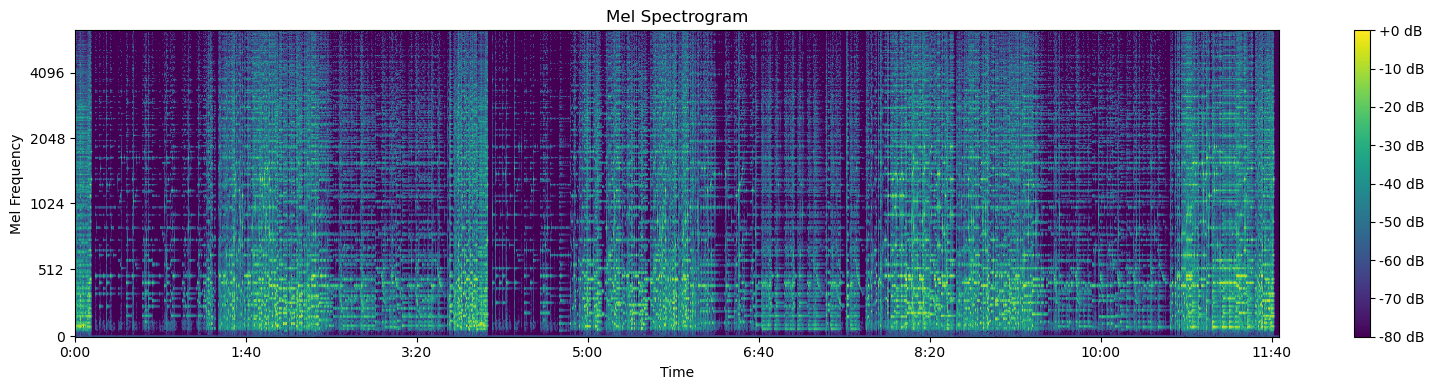

In [183]:
generateWave(os.path.join(root, df.head(100).sample(1).iloc[0]['midi_filename']), 'test.wav', '')
image, sr = getSpectogram('test.wav')
plotSpectogram(image, sr)

In [197]:
row = df.sort_values('duration').iloc[0]
midi_file = os.path.join(root, row['midi_filename'])
audio_file = os.path.join('output', row['my_audio'])
print(midi_file, audio_file)
makeChunks(midi_file, audio_file, 'test', 'test', clear=True)

maestro-v3.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--3.midi output/252.wav
